In [21]:
#single_image = r"C:\Users\danie\Desktop\tiny rainbow.jpg"
image_folder = r"C:\Users\midyr\Downloads\colorwheels"
image_pathway = r"C:\Users\midyr\Downloads\colorwheels\traffic4.jpg"

TOO_SMALL = 20
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
height = 128
width = 128

#epochs = 10 
#batch_size = 1 
total_images = 1

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import glob
import cv2
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D, InputLayer, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, color
from skimage.io import imread, imshow, imsave
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [23]:
def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [24]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg') #.png

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    
    print("processing", df_length, "photos for training")
    
    height_list= []
    width_list = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height_list.append(img.shape[0])
        width_list.append(img.shape[1])
        
    df["height"] = height_list
    df["width"] = width_list
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [25]:
def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
    print("PCA SHAPE",np.min(RGB_compressed),np.max(RGB_compressed))    
    return RGB_compressed

In [26]:
def rgb_pad(image):
    
    img_height = image.shape[0]
    print(height)
    img_width = image.shape[1]
    print(width)
    
    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    
    if img_height % 2 == 0:
        top = int((height - img_height)/ 2)
        bottom = int((height - img_height)/ 2)
    else: 
        top = int((height - (img_height-1))/ 2)
        bottom = int(((height - (img_height-1))/ 2)-1)

    if img_width % 2 == 0:
        left = int((width - img_width)/ 2)
        right = int((width - img_width)/ 2)
    else: 
        left = int((width - (img_width-1))/ 2)
        right = int(((width - (img_width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=WHITE)
    print(image.shape)
    print(np.min(image),np.max(image))

    return image

In [27]:
def prep_img(img_path):
    imgRGB = img_to_array(load_img(img_path))
    imgRGB = np.array(imgRGB, dtype=float)
    print('Padded:', np.min(imgRGB), np.max(imgRGB))



    image_size_category = shape(imgRGB) 
    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    if PCA_YN == "yes":
        RGB_compressed = pca_rgb(imgRGB, image_size_category)
        RGB_compressed = np.clip(RGB_compressed,0,1) * 255
        print("PCA ran")
    else:
        RGB_compressed = imgRGB
        print("PCA did not run")


    
    padded_image = rgb_pad(RGB_compressed)

    print('Padded:', np.min(padded_image), np.max(padded_image))
    X_LAB = color.rgb2lab(1.0/255*padded_image)[:,:,0] #1.0/255*padded_image
    print('X_LAB:', np.min(X_LAB), np.max(X_LAB))
    Y_LAB1 = color.rgb2lab(1.0/255*padded_image)[:,:,1:] #1.0/255*padded_image
    print('Y_LAB_org:', np.min(Y_LAB1), np.max(Y_LAB1))
    #Y_LAB = Y_LAB1 / 128
    Y_LAB = (Y_LAB1 + 128)/ 256
    print('Y_LAB:', np.min(Y_LAB), np.max(Y_LAB))


    print(X_LAB.shape)
    X = X_LAB.reshape(1, height, width, 1) #comment out when show predicted
    Y = Y_LAB.reshape(1, height, width, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [28]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

In [29]:
PCA_YN = "no"

#prep_image(single_image)

df = create_dataframe(image_folder)
prep_dataframe(df)

processing 4 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.0 100.0
Y_LAB_org: -39.4330982187246 84.65469092906922
Y_LAB: 0.345964460083107 0.8306823864416766
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 10.857046847039339 100.0
Y_LAB_org: -47.9568828345301 78.63110197654034
Y_LAB: 0.31266842642761683 0.8071527420958606
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 9.11485804502231 99.92678386264787
Y_LAB_org: -74.47312741367817 85.34851593081963
Y_LAB: 0.20908934604031965 0.8333926403547642
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.0 100.0
Y_LAB_org: -97.4591481396441 88.38876884930379
Y_L

# MODEL

In [30]:
BATCH_SIZE = 3
LEARNING_RATE = 0.001 #0.001
EPOCHS = 500 #100
KERNEL_SIZE = 2 
NUM_CLASSES = 32 #313 #2
IMAGE_WIDTH = 128 #128
IMAGE_HEIGHT = 128 #128
#SIGMA = 5

#early_stopping_cb = callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

In [31]:
def mode():
   
    model = tf.keras.Sequential([
    Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    UpSampling2D(size=(2, 2)),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation='softmax'),
    UpSampling2D(size=(2, 2)),
    Conv2D(2, kernel_size=1, activation='softmax', padding='same', dilation_rate=1, strides=1),
    UpSampling2D(size=(2, 2))])
    
    model.compile(optimizer ="adam", loss = "CategoricalCrossentropy", metrics = ["accuracy"])
    
    return model 

#?? Acitivation function and Loss function
#Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation='softmax'), UpSampling2D(size=(4, 4))])

In [32]:
model = mode()

In [33]:
model.build((1,128,128,1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (1, 128, 128, 32)         160       
                                                                 
 conv2d_25 (Conv2D)          (1, 64, 64, 32)           4128      
                                                                 
 batch_normalization_8 (Batc  (1, 64, 64, 32)          128       
 hNormalization)                                                 
                                                                 
 conv2d_26 (Conv2D)          (1, 64, 64, 64)           8256      
                                                                 
 conv2d_27 (Conv2D)          (1, 32, 32, 64)           16448     
                                                                 
 batch_normalization_9 (Batc  (1, 32, 32, 64)          256       
 hNormalization)                                      

In [34]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [35]:
len(X_train)

4

In [36]:
%%time
history = model.fit(train_data, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 2)  # add validation_split = 0.2

Epoch 1/500
4/4 - 2s - loss: 0.7099 - accuracy: 0.4749 - 2s/epoch - 569ms/step
Epoch 2/500
4/4 - 0s - loss: 0.7085 - accuracy: 0.5557 - 241ms/epoch - 60ms/step
Epoch 3/500
4/4 - 0s - loss: 0.7076 - accuracy: 0.6325 - 237ms/epoch - 59ms/step
Epoch 4/500
4/4 - 0s - loss: 0.7069 - accuracy: 0.6644 - 237ms/epoch - 59ms/step
Epoch 5/500
4/4 - 0s - loss: 0.7063 - accuracy: 0.6678 - 237ms/epoch - 59ms/step
Epoch 6/500
4/4 - 0s - loss: 0.7057 - accuracy: 0.6737 - 238ms/epoch - 59ms/step
Epoch 7/500
4/4 - 0s - loss: 0.7054 - accuracy: 0.6872 - 238ms/epoch - 60ms/step
Epoch 8/500
4/4 - 0s - loss: 0.7049 - accuracy: 0.6852 - 237ms/epoch - 59ms/step
Epoch 9/500
4/4 - 0s - loss: 0.7046 - accuracy: 0.6877 - 240ms/epoch - 60ms/step
Epoch 10/500
4/4 - 0s - loss: 0.7046 - accuracy: 0.7110 - 237ms/epoch - 59ms/step
Epoch 11/500
4/4 - 0s - loss: 0.7042 - accuracy: 0.7096 - 239ms/epoch - 60ms/step
Epoch 12/500
4/4 - 0s - loss: 0.7040 - accuracy: 0.7125 - 241ms/epoch - 60ms/step
Epoch 13/500
4/4 - 0s - los

4/4 - 0s - loss: 0.7029 - accuracy: 0.8655 - 201ms/epoch - 50ms/step
Epoch 102/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8639 - 216ms/epoch - 54ms/step
Epoch 103/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8646 - 208ms/epoch - 52ms/step
Epoch 104/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8600 - 210ms/epoch - 52ms/step
Epoch 105/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8612 - 200ms/epoch - 50ms/step
Epoch 106/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8593 - 201ms/epoch - 50ms/step
Epoch 107/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8612 - 209ms/epoch - 52ms/step
Epoch 108/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8623 - 212ms/epoch - 53ms/step
Epoch 109/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8637 - 200ms/epoch - 50ms/step
Epoch 110/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8616 - 203ms/epoch - 51ms/step
Epoch 111/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8641 - 241ms/epoch - 60ms/step
Epoch 112/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8657 - 224ms/epoch - 56ms/step
Epoch 113/500
4/4 

Epoch 200/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8651 - 207ms/epoch - 52ms/step
Epoch 201/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8602 - 203ms/epoch - 51ms/step
Epoch 202/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8658 - 196ms/epoch - 49ms/step
Epoch 203/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8629 - 195ms/epoch - 49ms/step
Epoch 204/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8637 - 253ms/epoch - 63ms/step
Epoch 205/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8632 - 196ms/epoch - 49ms/step
Epoch 206/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8630 - 202ms/epoch - 50ms/step
Epoch 207/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8621 - 200ms/epoch - 50ms/step
Epoch 208/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8622 - 201ms/epoch - 50ms/step
Epoch 209/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8604 - 199ms/epoch - 50ms/step
Epoch 210/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8620 - 197ms/epoch - 49ms/step
Epoch 211/500
4/4 - 0s - loss: 0.7030 - accuracy: 0.8492 - 197ms/epoch - 49ms/step
Epoc

Epoch 299/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8629 - 195ms/epoch - 49ms/step
Epoch 300/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8651 - 193ms/epoch - 48ms/step
Epoch 301/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8638 - 192ms/epoch - 48ms/step
Epoch 302/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8658 - 195ms/epoch - 49ms/step
Epoch 303/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8640 - 196ms/epoch - 49ms/step
Epoch 304/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8653 - 206ms/epoch - 51ms/step
Epoch 305/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8643 - 195ms/epoch - 49ms/step
Epoch 306/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8652 - 196ms/epoch - 49ms/step
Epoch 307/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8647 - 193ms/epoch - 48ms/step
Epoch 308/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8644 - 193ms/epoch - 48ms/step
Epoch 309/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8648 - 198ms/epoch - 50ms/step
Epoch 310/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8659 - 197ms/epoch - 49ms/step
Epoc

Epoch 398/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8686 - 215ms/epoch - 54ms/step
Epoch 399/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8686 - 209ms/epoch - 52ms/step
Epoch 400/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8687 - 201ms/epoch - 50ms/step
Epoch 401/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8685 - 213ms/epoch - 53ms/step
Epoch 402/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8688 - 223ms/epoch - 56ms/step
Epoch 403/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8684 - 217ms/epoch - 54ms/step
Epoch 404/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8688 - 217ms/epoch - 54ms/step
Epoch 405/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8686 - 196ms/epoch - 49ms/step
Epoch 406/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8686 - 199ms/epoch - 50ms/step
Epoch 407/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8687 - 206ms/epoch - 51ms/step
Epoch 408/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8686 - 198ms/epoch - 49ms/step
Epoch 409/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8686 - 202ms/epoch - 50ms/step
Epoc

Epoch 497/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8658 - 219ms/epoch - 55ms/step
Epoch 498/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8680 - 206ms/epoch - 52ms/step
Epoch 499/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8650 - 210ms/epoch - 52ms/step
Epoch 500/500
4/4 - 0s - loss: 0.7029 - accuracy: 0.8679 - 209ms/epoch - 52ms/step
Wall time: 1min 48s


In [37]:
#filename = 'Singular_Model'
#model2.save(filename)
#saved_model = load_model("Singular Model")

# PREDICTION

In [38]:
def get_photo(image):
    prep_color, prep_bw = prep_img(image_pathway)
    test_predict = model.predict(prep_bw)
    #print(test_predict)
    print('test_range_A:', np.min(test_predict[:,:,0]), np.max(test_predict[:,:,0]))
    print('test_range_B:', np.min(test_predict[:,:,1]), np.max(test_predict[:,:,1]))
    
    test_predict_reshaped= test_predict[0,:,:,:]
    #test_predict_reshaped = test_predict_reshaped*128
    test_predict_reshaped = (test_predict_reshaped*256)-128
    BW_reshaped  = prep_bw[0,:,:,:]
    
    print('test_reshaped_A:', np.min(test_predict_reshaped[:,:,0]), np.max(test_predict_reshaped[:,:,0]))
    print(len(np.unique(test_predict_reshaped[:,:,0]))) #, return_counts=True
    print('test_reshaped_B:', np.min(test_predict_reshaped[:,:,1]), np.max(test_predict_reshaped[:,:,1]))
    test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))
    test_merged_rgb = color.lab2rgb(test_merged_LAB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(test_merged_rgb)

Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.0 100.0
Y_LAB_org: -97.4591481396441 88.38876884930379
Y_LAB: 0.11930020257951524 0.845268628317593
(128, 128)
image processed
test_range_A: 0.28159904 0.7184009
test_range_B: 0.28159904 0.7184009
test_reshaped_A: -43.33268 56.629852
1024
test_reshaped_B: -56.629845 43.332687


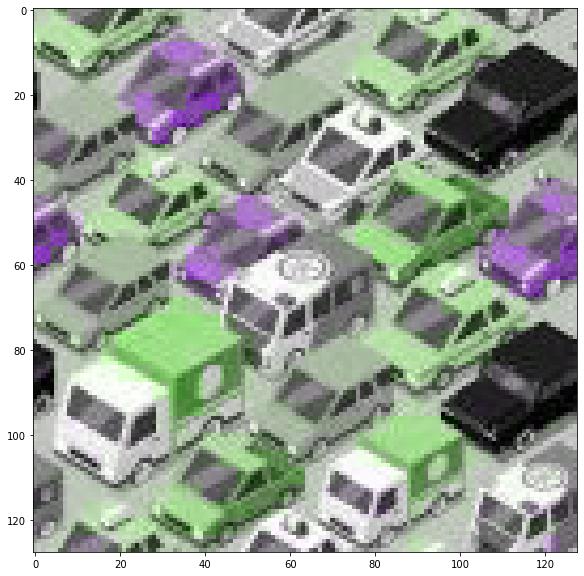

In [39]:
get_photo(image_pathway)

In [40]:
#prbs = (32, 32, 313)
#np.reshape(prbs, (-1, 313))
data = np.load('bin_centers.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'bin_centers.npy'